# CoCaD (Counterfactual Causal DP)

## Load the necessary stuff

N, sentences_list

In [ ]:
## Loading our nodes and sentences back:

import os
import json

# --- CODE TO RETRIEVE FILES ---

# 1. Define the directory
output_directory = "saved_stuff"

# --- FILE 1: NODE ENTITIES ---

node_filename = "node_entities_output.json"
node_file_path = os.path.join(output_directory, node_filename)
retrieved_nodes = None

try:
    print(f"Attempting to load entities from: {node_file_path}")
    
    with open(node_file_path, 'r', encoding='utf-8') as f:
        retrieved_nodes = json.load(f)
        
    print(f"✅ Success: Entities loaded from {node_file_path}")
    
    # Access the list of entities
    entities_list = retrieved_nodes.get("entities", [])
    
    print("\n--- Entities Summary ---")
    print(f"Total entities retrieved: {len(entities_list)}")
    print("\nParsed JSON (Final Union):\n", json.dumps(entities_list, indent=2))
    
except FileNotFoundError:
    print(f"\n❌ Error: Entity file not found at {node_file_path}.")
except json.JSONDecodeError as e:
    print(f"\n❌ Error: Failed to parse entity JSON file. Error: {e}")
except Exception as e:
    print(f"\n❌ An unexpected error occurred while loading entities: {e}")


# --- FILE 2: SEGMENTED SENTENCES ---

# 1. Define the filename and path for the second file
sentence_filename = "segmented_sentences.json"
sentence_file_path = os.path.join(output_directory, sentence_filename)
retrieved_sentences = None

try:
    print(f"\nAttempting to load sentences from: {sentence_file_path}")
    
    with open(sentence_file_path, 'r', encoding='utf-8') as f:
        retrieved_sentences = json.load(f)
        
    print(f"✅ Success: Sentences loaded from {sentence_file_path}")
    
    # Access the list of sentences
    sentences_list = retrieved_sentences.get("sentences", [])
    
    print("\n--- Sentences Summary ---")
    print(f"Total sentences retrieved: {len(sentences_list)}")
    print("\nParsed JSON (Final Union):\n", json.dumps(sentences_list, indent=2))
    
except FileNotFoundError:
    print(f"\n❌ Error: Sentence file not found at {sentence_file_path}.")
except json.JSONDecodeError as e:
    print(f"\n❌ Error: Failed to parse sentence JSON file. Error: {e}")
except Exception as e:
    print(f"\n❌ An unexpected error occurred while loading sentences: {e}")


## --- END RETRIEVE CODE ---

In [ ]:
import os
import json
from typing import List, Dict, Any

# --- CODE TO RETRIEVE PARAGRAPHS ---

# 1. Define the directory and filename (matching your save location)
output_directory = "saved_stuff"
json_filename = "segmented_paragraphs.json"

# 2. Construct the full file path
file_path = os.path.join(output_directory, json_filename)

# Initialize the target variables
retrieved_data: Dict[str, Any] = {}
paragraphs_list: List[str] = []

print(f"Attempting to load paragraphs from: {file_path}")

# 3. Attempt to open and load the JSON file
try:
    # Open the file in read mode ('r')
    with open(file_path, 'r', encoding='utf-8') as f:
        # Use json.load() to deserialize the JSON content into the dictionary
        retrieved_data = json.load(f)
        
    # 4. Safely extract the list from the 'paragraphs' key
    paragraphs_list = retrieved_data.get("paragraphs", [])
    
    print(f"\n✅ Success: Paragraphs successfully loaded from {file_path}")
    
    # --- Data Inspection and Explanation ---
    print("\n--- Retrieved Data Details ---")
    print(f"Total paragraphs retrieved: {len(paragraphs_list)}")
    
    for i, para in enumerate(paragraphs_list, start=1):
        print(f"Paragraph {i}")
        print(para)

    
except FileNotFoundError:
    print(f"\n❌ Retrieval Error: File not found at {file_path}.")
    print("Detail: Ensure the 'saved_stuff' folder exists and contains 'segmented_paragraphs.json'.")
    
except json.JSONDecodeError as e:
    print(f"\n❌ Retrieval Error: Failed to parse JSON file at {file_path}.")
    print(f"Detail: The file exists but contains invalid JSON syntax (e.g., missing quotes, commas, or mismatched brackets). Error: {e}")
    
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

# The 'paragraphs_list' variable now holds your recovered data (or an empty list if loading failed).
# print(paragraphs_list) # Uncomment this to see the full list directly

In [ ]:
# Clean paragraphs: remove unnecessary newlines
cleaned_paragraphs = []
for p in paragraphs_list:
    # Replace multiple newlines with a single space
    cleaned = " ".join(p.split())
    cleaned_paragraphs.append(cleaned)

paragraphs_list = cleaned_paragraphs


In [ ]:
N = entities_list
Extracted_Sentences = sentences_list
Paragraphs_List = paragraphs_list

In [ ]:
N = {f"N{i}": name for i, name in enumerate(N, start=1)}
Extracted_Sentences = {f"S{i}": name for i, name in enumerate(Extracted_Sentences, start=1)}
Paragraphs_List = {f"P{i}": name for i, name in enumerate(Paragraphs_List, start=1)}

In [ ]:
for key in sorted(Extracted_Sentences.keys(), key=lambda x: int(x[1:])):
    print(key, ":", Extracted_Sentences[key])


In [ ]:
import collections
from typing import Dict, Tuple, List, Any

# Initialize T_map: maps node_id to a list of (paragraph_id, sentence_id) tuples
T_map: Dict[str, List[Tuple[str, str]]] = collections.defaultdict(list)

print("Starting node-to-context alignment...")

# 1. Iterate through every node (entity)
for node_id, entity_text in N.items():
    # Sanitize the entity text to handle potential punctuation issues during matching
    entity_text_clean = entity_text.strip()
    
    # Check if the node is empty (unlikely but safe)
    if not entity_text_clean:
        continue

    # 2. Iterate through every sentence to find the direct source
    for sentence_id, sentence_text in Extracted_Sentences.items():
        
        # Check if the entity string is contained within the sentence text
        if entity_text_clean in sentence_text:
            
            # 3. If found in a sentence, find the paragraph that contains that sentence ID
            # This requires a nested check, as we don't have a direct S_ID -> P_ID map.
            # We must iterate through the paragraphs to determine which one contains the full sentence.
            
            paragraph_found = False
            for paragraph_id, paragraph_text in Paragraphs_List.items():
                
                # Check if the *full sentence* is contained within the paragraph text
                if sentence_text.strip() in paragraph_text:
                    
                    # 4. Record the mapping: Node ID -> (Paragraph ID, Sentence ID)
                    T_map[node_id].append((paragraph_id, sentence_id))
                    paragraph_found = True
                    # Optimization: Since the sentence should only belong to one paragraph, break the inner loop
                    break 

            # If the sentence wasn't found in any paragraph (e.g., due to fragmentation), skip recording.
            if not paragraph_found:
                 print(f"Warning: Sentence {sentence_id} containing '{entity_text_clean}' was not cleanly mapped to a paragraph.")

print("\n--- T_map Generation Complete ---")
print(f"Total nodes mapped: {len(T_map)}")
print("-" * 40)



In [ ]:
from typing import Dict, List, Any, Tuple
import itertools
import pprint

# Initialize Invert_T_map
Invert_T_map: Dict[str, Dict[str, Any]] = {}

# 1. Initialize the structure and copy paragraph content
for p_id, content in Paragraphs_List.items():
    Invert_T_map[p_id] = {
        'context': content,
        'Nodes': set(), 
        'pairs_to_check': [] # Initialize new field
    }

# 2. Iterate through the T_map to map nodes to paragraphs
for node_id, locations in T_map.items():
    for p_id, s_id in locations:
        if p_id in Invert_T_map:
            Invert_T_map[p_id]['Nodes'].add(node_id)


# 3. Convert the temporary sets back to lists and generate directed pairs
for p_id in Invert_T_map:
    # 3a. Get the sorted list of nodes
    nodes_set = Invert_T_map[p_id]['Nodes']
    nodes_list = sorted(list(nodes_set))
    
    # Initialize the list for all directed pairs
    all_directed_pairs: List[Tuple[str, str]] = []
    
    # 3b. Generate all unique, unordered pairs (combinations of size 2)
    # The output of combinations is a list of tuples, e.g., [('N1', 'N2'), ('N1', 'N3')]
    for pair in itertools.combinations(nodes_list, 2):
        # 1. Add the pair in the original order (A, B)
        all_directed_pairs.append(pair)
        
        # 2. Add the reverse pair (B, A) to create the directed pair set
        reverse_pair = (pair[1], pair[0])
        all_directed_pairs.append(reverse_pair)
    
    # 3c. Assign the final lists back to the map
    Invert_T_map[p_id]['Nodes'] = nodes_list
    Invert_T_map[p_id]['pairs_to_check'] = all_directed_pairs # Assigned the directed list


# --- Final Output ---
print("\n--- Invert_T_map Generation Complete (Directed Pairs) ---")
print(f"Total paragraphs mapped: {len(Invert_T_map)}")

pprint.pprint(Invert_T_map)

In [ ]:
import json
import os
import pprint

# --- Define the file path and directory (must match save code) ---
SAVE_DIR = "saved_stuff"
FILE_NAME = "relation_map_data.json"
FULL_PATH = os.path.join(SAVE_DIR, FILE_NAME)

# Initialize the variable before loading
RELATION_MAP = {}

# 1. Load the dictionary from JSON
try:
    with open(FULL_PATH, 'r') as f:
        # We use json.load() to read the data from the file object 'f'
        RELATION_MAP = json.load(f)
    
    print(f"✅ Successfully loaded RELATION_MAP from: {FULL_PATH}")
    print(f"Total paragraphs loaded: {len(RELATION_MAP)}")
    
    # Optional: Print a snippet of the loaded data to confirm
    print("\nSnippet of Loaded Data:")
    pprint.pprint(RELATION_MAP['P1'])
    
except FileNotFoundError:
    print(f"❌ Error: File not found at {FULL_PATH}. Did you run the save code first?")
except Exception as e:
    print(f"❌ Error loading file: {e}")

# Combine all of the above contents to form ExtractedTriplets
 
# Initialize an empty list to hold all triplets
ExtractedTriplets = []

# Use a list comprehension for the most efficient and Pythonic way to combine lists
# Iterates through the values (which are lists of triplets) in the RELATION_MAP dictionary
# and extends the ExtractedTriplets list.
for p_id, triplets_list in RELATION_MAP.items():
    ExtractedTriplets.extend(triplets_list)
    # Optional: You can also print the number of triplets added per paragraph
    # print(f"Added {len(triplets_list)} triplets from {p_id}")

print(f"✅ Total combined triplets: {len(ExtractedTriplets)}")
# print("\nFirst 5 combined triplets:")
# print(ExtractedTriplets[:5]) # Uncomment to verify the data structure

In [ ]:
# Lets do our clustering

import numpy as np
import time
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Any, Tuple


# --- 1. Data Extraction and Deduplication ---
relation_phrases = [t['relation_phrase'] for t in ExtractedTriplets]
unique_phrases = sorted(list(set(relation_phrases)))
num_unique_phrases = len(unique_phrases)

print(f"Total unique relation phrases found: {num_unique_phrases}")
# Example: ['ANNOUNCED_ON', 'BEGAN_ON', 'CAUSED_FINANCIAL_RUIN_FOR', ...]

# --- 2. Dynamic K Determination ---
K_MAX = 10
K = min(K_MAX, num_unique_phrases)

print(f"Clustering target K set to: {K}")

# --- 3. Embedding using Sentence Embedder f_embed ---
# We use all-MiniLM-L6-v2, a fast and highly effective embedding model.
# This model acts as the sentence embedder function f_embed.
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Starting phrase embedding...")
start_time = time.time()

# The resulting matrix contains the vector v_rel for each phrase.
embeddings = model.encode(unique_phrases, show_progress_bar=False)

end_time = time.time()
print(f"Embedding completed in {end_time - start_time:.2f} seconds.")
print(f"Embedding shape: {embeddings.shape}")

# --- 4. Clustering (K-Means) ---
ClusterMap: Dict[str, int] = {}

if K >= 1:
    # We use K-Means to cluster the semantic vectors.
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    
    # Fit the model and predict the cluster labels (0-indexed)
    cluster_labels = kmeans.fit_predict(embeddings)

    # --- 5. Create ClusterMap and Assign 1-Based IDs ---
    # Map each phrase to its cluster label (0-indexed) and then convert to 1-based ID.
    for phrase, label in zip(unique_phrases, cluster_labels):
        # Assign unique number starting from 1
        ClusterMap[phrase] = int(label) + 1
else:
    # Handle the degenerate case where there are no unique phrases
    print("Warning: No unique phrases to cluster.")

# --- 6. Verification and Output ---
print("\n--- Final Cluster Map ---")
# Use a dictionary comprehension to group phrases by cluster ID for display
clusters_grouped = {}
for phrase, c_id in ClusterMap.items():
    if c_id not in clusters_grouped:
        clusters_grouped[c_id] = []
    clusters_grouped[c_id].append(phrase)

for c_id, phrases in sorted(clusters_grouped.items()):
    print(f"\nCluster {c_id}: (n={len(phrases)})")
    print("-------------------------")
    for phrase in phrases:
        print(f" - {phrase}")

print(f"\nClusterMap size: {len(ClusterMap)}")
# print("\nRaw ClusterMap Dictionary (First 5 items):")
# print(dict(list(ClusterMap.items())[:5]))

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from typing import List, Dict, Any

# --- 0. Node mapping: N1..Nn -> integer indices (1..NUM_NODES), 0 unused ---
node_to_idx: Dict[str, int] = {}

for node_id_str in N.keys():
    # remove leading 'N'
    numerical_part = node_id_str[1:]
    node_index = int(numerical_part)  # e.g. "10" -> 10
    node_to_idx[node_id_str] = node_index

NUM_NODES = len(N)
MATRIX_DIM = NUM_NODES + 1  # keeping index 0 unused, as per your earlier design

# --- 1. Number of clusters ---
K_CLUSTER = max(ClusterMap.values())  # Cluster IDs are 1..K

print(f"Total number of unique nodes (N): {NUM_NODES}")
print(f"Total number of relation types (K): {K_CLUSTER}")

# --- 2. Initialize K builders for COO matrices ---
# Each W_k has its own data/row/col list
W_data: List[List[float]] = [[] for _ in range(K_CLUSTER)]
W_row:  List[List[int]]   = [[] for _ in range(K_CLUSTER)]
W_col:  List[List[int]]   = [[] for _ in range(K_CLUSTER)]

print("\nPopulating sparse matrix builders in a single pass...")

for triplet in ExtractedTriplets:
    relation_phrase = triplet['relation_phrase']
    confidence      = float(triplet['confidence'])

    cluster_id = ClusterMap.get(relation_phrase)
    if cluster_id is None:
        print(f"Warning: Phrase '{relation_phrase}' not found in ClusterMap. Skipping.")
        continue

    # cluster_id is 1-based; our list index is 0-based
    matrix_index = cluster_id - 1

    # subject/object indices
    row_idx = node_to_idx[triplet['subject_id']]
    col_idx = node_to_idx[triplet['object_id']]

    # append to that cluster's lists
    W_data[matrix_index].append(confidence)
    W_row[matrix_index].append(row_idx)
    W_col[matrix_index].append(col_idx)

# --- 3. Build K COO matrices from those lists ---
W_k_matrices: List[coo_matrix] = []

print("\nConstructing final sparse matrices (W_1 to W_K)...")

for k in range(K_CLUSTER):
    # Even if the lists are empty, coo_matrix will just give an empty matrix
    W_k = coo_matrix(
        (W_data[k], (W_row[k], W_col[k])),
        shape=(MATRIX_DIM, MATRIX_DIM)
    )
    W_k_matrices.append(W_k)
    print(f"W_{k+1} (Cluster {k+1}): "
          f"Shape={W_k.shape}, Entries={W_k.nnz}, Data Sum={W_k.data.sum():.4f}")

print(f"\nSuccessfully created {len(W_k_matrices)} sparse matrices.")


import numpy as np
from scipy.sparse import dok_matrix, csr_matrix
from typing import List

def finalize_relation_matrix(
    data_list: List[float],
    row_list: List[int],
    col_list: List[int],
    n_nodes: int
) -> csr_matrix:
    """
    Build an N x N sparse matrix where, for each (row, col), we store
    the MAX of all confidence scores seen for that edge in this cluster.
    """
    if not data_list:
        # return empty N x N matrix
        return csr_matrix((n_nodes, n_nodes), dtype=np.float32)

    # DOK is great for incremental assignment
    W_dok = dok_matrix((n_nodes, n_nodes), dtype=np.float32)

    for data, row, col in zip(data_list, row_list, col_list):
        value = float(data)
        current_max = W_dok[row, col]  # 0.0 if not yet set
        if value > current_max:
            W_dok[row, col] = value

    # convert to CSR for fast downstream ops
    return W_dok.tocsr()



In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from typing import List

Final_Aggregated_W: List[csr_matrix] = []

print("\n--- Starting Max Aggregation for All Clusters ---")

for k_index in range(K_CLUSTER):
    raw_data_list = W_data[k_index]
    row_list_k    = W_row[k_index]
    col_list_k    = W_col[k_index]

    if not raw_data_list:
        # No edges in this cluster: just push an empty matrix
        empty_csr = csr_matrix((MATRIX_DIM, MATRIX_DIM), dtype=np.float32)
        Final_Aggregated_W.append(empty_csr)
        print(f"✅ Final W_{k_index + 1}: EMPTY matrix, Shape={empty_csr.shape}")
        continue

    try:
        data_array_k = np.asarray(raw_data_list, dtype=np.float32)
    except Exception as e:
        print(f"❌ ERROR in W_{k_index + 1} data conversion: {e}")
        continue

    # Call aggregation: note MATRIX_DIM = NUM_NODES + 1
    Final_W_k_CSR = finalize_relation_matrix(
        data_array_k.tolist(),
        row_list_k,
        col_list_k,
        MATRIX_DIM
    )

    Final_Aggregated_W.append(Final_W_k_CSR)

    print(f"✅ Final W_{k_index + 1}: "
          f"Shape={Final_W_k_CSR.shape}, "
          f"Unique Edges={Final_W_k_CSR.nnz}, "
          f"Total Weight={Final_W_k_CSR.data.sum():.4f}")

print(f"\nSuccessfully created {len(Final_Aggregated_W)} final, maximized CSR matrices.")


In [ ]:
from scipy.sparse import coo_matrix

print("\n--- Final Maximized Relational Matrices (W_k) ---")
print(f"Total Matrices in List: {len(Final_Aggregated_W)}\n")

for k_index, final_Wk in enumerate(Final_Aggregated_W):
    cluster_id = k_index + 1
    print()
    print(f"**Matrix W_{cluster_id} (Cluster {cluster_id})**")
    print(f"Shape: {final_Wk.shape}, "
          f"Unique Edges (nnz): {final_Wk.nnz}, "
          f"Total Weight: {final_Wk.data.sum():.4f}")

    if final_Wk.nnz == 0:
        print("  [Matrix is empty (no relationships in this cluster)]")
        continue

    coo_wk: coo_matrix = final_Wk.tocoo()

    print("  Non-Zero Edges (Subject Index -> Object Index | Max Confidence Score):")
    for r, c, d in zip(coo_wk.row, coo_wk.col, coo_wk.data):
        print(f"  ({r} -> {c}) | Score: {d:.4f}")


In [ ]:
A_w = Final_Aggregated_W
N = N
T_map = T_map

In [ ]:
## Retrieve the K1

import json
import numpy as np

load_path = "saved_stuff/k1.json"

with open(load_path, "r") as f:
    loaded_list = json.load(f)

# Convert back to (int, np.int64) tuple format
K1_loaded = [(int(a), np.int64(b)) for (a, b) in loaded_list]

print(f"Loaded K1 from {load_path}")
print(K1_loaded[:10])  # preview


In [ ]:
## Retrieve the Z (GAE embeddings)

import torch

load_path = "saved_stuff/Z.pt"

Z_loaded = torch.load(load_path, map_location="cpu")  # safe for CPU use

print(f"Loaded Z from: {load_path}")
print("Shape:", Z_loaded.shape)
print("Dtype:", Z_loaded.dtype)


In [ ]:
from pprint import pprint

pprint(Z_loaded.shape)

In [ ]:
## Retrieve the A_co_occur

from scipy.sparse import load_npz

load_path = "saved_stuff/A_co_occur.npz"

A_co_occur_loaded = load_npz(load_path)

print(f"Loaded A_co_occur from: {load_path}")
print(A_co_occur_loaded)


In [ ]:
E_prior = K1_loaded
A_co_occur = A_co_occur_loaded
Z = Z_loaded

In [ ]:
from pprint import pprint

pprint(E_prior)

In [ ]:
print(len(E_prior))

#### Brief Summary of Pre-CoCaD filteration part:

1. Structural Filter (GAE/ANN): You begin with $N^2$ possible pairs. The GAE/ANN process filters this down to the structurally plausible set, $\mathbf{C}_1$.
2. Input to Semantic Filter: The $\mathbf{C}_1$ set is the full input to the Semantic Filter.
3. Semantic Filter (Verification/CPC): This stage rigorously verifies and classifies the plausibility of each link in $\mathbf{C}_1$. It discards links that are semantically implausible, not supported by context, or lack mechanism/temporality.
4. Final Output: The resulting, highly curated, high-quality set is $\mathbf{K}_2$.$$\mathbf{C}_1 \xrightarrow[\text{Verification, Classification}]{\text{Semantic Filter}} \mathbf{K}_2$$

The final $\mathbf{K}_2$ set represents your ultimate $\mathbf{E}_{\text{prior}}$, containing only the most promising candidates ready for the final causal algorithm.

#### Note: The loaded $E_{prior}$ is supposed to be direction-agnostic, meaning if it contains node (i,j) it should contain node (j,i) also..

Reason: Structural Completeness

The primary goal of $E_{\text{prior}}$ is to provide a complete list of plausible hypotheses for the final causal discovery algorithm.
1. Symmetry of Evidence: The initial structural score ($Z_i Z_j^T$) is symmetric. If $i$ is structurally close to $j$, then $j$ is equally close to $i$.
2. Causal Test Requirement: The final causal discovery phase must individually test the hypothesis $i \to j$ against the hypothesis $j \to i$. If you only included $(i, j)$, you would prematurely exclude the possibility that $j$ causes $i$.
Therefore, to maintain structural completeness, both directed hypotheses must be present in $E_{\text{prior}}$.

In [ ]:
import numpy as np
from typing import List, Tuple, Set


def enforce_bidirectional_symmetry(initial_E_prior: List[Tuple[int, np.int64]]) -> List[Tuple[int, int]]:
    """
    Takes a list of directed pairs (i, j) and ensures the inverse pair (j, i) 
    also exists, converting all elements to native Python integers (int) for cleanup.
    """
    
    # 1. Convert initial list to a Set of tuples (i, j) for fast lookup and deduplication.
    # Convert np.int64 to standard Python int during this step.
    full_set: Set[Tuple[int, int]] = set()
    
    # First pass: Populate the set with existing and inverse pairs
    for i_np, j_np in initial_E_prior:
        # Convert np.int64 to standard Python int
        i = int(i_np)
        j = int(j_np)
        
        # Add the original pair
        full_set.add((i, j))
        
        # Add the inverse pair (j, i)
        full_set.add((j, i))
        
    # 2. Convert the final Set back to a List
    # Sorting is optional but makes debugging easier and guarantees a deterministic output order.
    final_E_prior = sorted(list(full_set))
    
    return final_E_prior

# Update the E_prior list in place
E_prior = enforce_bidirectional_symmetry(E_prior)

print("--- E_prior Symmetry Enforcement Complete ---")
print(f"Initial size (approx): {29}")
print(f"Final size: {len(E_prior)} (Should be ~2x the number of unique links)")
print("\nSnippet of Final E_prior:")
print(E_prior[:5])
print("...")
print(E_prior[-5:])

## Core of CoCaD

### Building (a) $W_{direct}$

#### (i).  $f_{structural}$ (Our GNN intervention score)

In [ ]:
import pprint

pprint.pprint(len(Z))

In [ ]:
import numpy as np
import pprint
from typing import List, Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from scipy.sparse import csr_matrix, lil_matrix
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import from_scipy_sparse_matrix

# ---------------------------------------------------------
# HYPERPARAMETERS
# ---------------------------------------------------------
B_ENSEMBLE = 5          # Number of GNNs in the ensemble
GCN_HIDDEN = 64         # Hidden dimension of GCN
GCN_LATENT = 64         # Latent dimension of GCN/GAE
GCN_EPOCHS = 200        # Training epochs per GCN
LEARNING_RATE = 0.005
WEIGHT_DECAY = 5e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------------------------------------------------------
# 1. GCN ENCODER (same spirit as your earlier code)
#    cached=False so that changes to edge_index matter.
# ---------------------------------------------------------

class GCNEncoder(nn.Module):
    """Two-layer GCN encoder for GAE."""
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        # IMPORTANT: cached=False so each new graph structure is respected
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=False)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=False)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# ---------------------------------------------------------
# 2. BUILD BASE GRAPH (X = Z_loaded, A = A_co_occur + E_prior edges)
# ---------------------------------------------------------

def build_base_graph(
    Z_loaded,               # can be np.ndarray or torch.Tensor
    A_co_occur: csr_matrix,
    E_prior: List[Tuple[int, Any]]
) -> Tuple[torch.Tensor, csr_matrix, torch.Tensor]:
    """
    Uses the learned Z_loaded as node features X.
    1) Augments A_co_occur with all edges from E_prior (if missing).
    2) Symmetrizes the adjacency and builds a PyG edge_index.
    """

    assert isinstance(A_co_occur, csr_matrix), "A_co_occur must be a CSR matrix"

    # ---- Handle Z_loaded being np.ndarray OR torch.Tensor ----
    if isinstance(Z_loaded, np.ndarray):
        x = torch.from_numpy(Z_loaded.astype(np.float32))
    elif isinstance(Z_loaded, torch.Tensor):
        x = Z_loaded.float()  # just ensure float32
    else:
        raise TypeError(f"Z_loaded must be np.ndarray or torch.Tensor, got {type(Z_loaded)}")

    # ---- Start from a mutable adjacency (LIL) ----
    A_lil = A_co_occur.tolil()

    # ---- Add (i, j) edges from E_prior if not present ----
    for (i_raw, j_raw) in E_prior:
        i = int(i_raw) - 1  # convert 1-based -> 0-based
        j = int(j_raw) - 1
        if i == j:
            continue
        # undirected: add both (i, j) and (j, i)
        A_lil[i, j] = 1.0
        A_lil[j, i] = 1.0

    # Convert back to CSR
    A_aug = A_lil.tocsr().astype(np.float32)

    # Symmetrize adjacency again (safety; OR with transpose)
    A_sym = ((A_aug + A_aug.T) > 0).astype(np.float32)

    # Convert to edge_index (PyG format)
    edge_index, _ = from_scipy_sparse_matrix(A_sym)

    return x, A_sym, edge_index


# ---------------------------------------------------------
# 3. TRAIN A SINGLE GAE MODEL
# ---------------------------------------------------------

def train_single_gae(
    x: torch.Tensor,
    edge_index: torch.Tensor,
    d_in: int,
    d_hidden: int,
    d_latent: int,
    epochs: int,
    seed: int
) -> GAE:
    """
    Train a single GAE model with a 2-layer GCN encoder.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    x = x.to(device)
    edge_index = edge_index.to(device)

    encoder = GCNEncoder(d_in, d_hidden, d_latent).to(device)
    model = GAE(encoder).to(device)

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    data = Data(x=x, edge_index=edge_index)

    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()

        if epoch == 1 or epoch % 50 == 0:
            print(f"[Seed {seed}] Epoch {epoch:03d} | Loss: {loss.item():.4f}")

    return model


# ---------------------------------------------------------
# 4. BUILD ENSEMBLE OF GNNs
# ---------------------------------------------------------

def build_gnn_ensemble(
    x: torch.Tensor,
    edge_index: torch.Tensor,
    d_in: int,
    d_hidden: int,
    d_latent: int,
    epochs: int,
    B: int
) -> List[GAE]:
    """
    Train B different GAE models with different seeds.
    """
    ensemble: List[GAE] = []
    for b in range(B):
        seed = 100 + b  # arbitrary offset
        print(f"\n=== Training GAE model {b+1}/{B} (seed={seed}) ===")
        model_b = train_single_gae(
            x=x,
            edge_index=edge_index,
            d_in=d_in,
            d_hidden=d_hidden,
            d_latent=d_latent,
            epochs=epochs,
            seed=seed
        )
        ensemble.append(model_b)
    return ensemble


# ---------------------------------------------------------
# 5. GNN PREDICTION FOR A NODE j
# ---------------------------------------------------------

def gnn_predict_node_embedding(
    model: GAE,
    x: torch.Tensor,
    edge_index: torch.Tensor,
    node_id_1based: int
) -> np.ndarray:
    """
    Proper f_GNN,b(N_j, X) via a 2-layer GCN encoder:
    Runs the model on the graph defined by edge_index
    and returns node j's latent embedding.
    node_id_1based: node index in [1..N]
    """
    model.eval()
    x = x.to(device)
    edge_index = edge_index.to(device)

    with torch.no_grad():
        z = model.encode(x, edge_index)  # shape: [N_nodes, d_latent]

    j_idx = node_id_1based - 1
    z_j = z[j_idx].detach().cpu().numpy()
    # Normalize to unit vector (optional but nice for cosine distance)
    norm = np.linalg.norm(z_j) + 1e-12
    return z_j / norm


# ---------------------------------------------------------
# 6. COSINE DISTANCE
# ---------------------------------------------------------

def cosine_distance(v1: np.ndarray, v2: np.ndarray) -> float:
    """
    1 - cosine similarity between two 1D vectors.
    """
    v1 = v1.flatten()
    v2 = v2.flatten()
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2)) + 1e-12
    cos_sim = float(np.dot(v1, v2) / denom)
    return 1.0 - cos_sim


# ---------------------------------------------------------
# 7. MAIN: STRUCTURAL EFFECT SCORES USING GNN ENSEMBLE
#    *** NODE DELETION VERSION ***
# ---------------------------------------------------------

def compute_structural_effect_scores(
    Z_loaded,                 # np.ndarray or torch.Tensor
    A_co_occur: csr_matrix,
    E_prior: List[Tuple[int, Any]],
    B_ensemble: int = B_ENSEMBLE,
    gcn_hidden: int = GCN_HIDDEN,
    gcn_latent: int = GCN_LATENT,
    gcn_epochs: int = GCN_EPOCHS
) -> Dict[Tuple[int, int], Dict[str, float]]:
    """
    Implements f_structural via a bootstrap ensemble of GNNs (NODE DELETION):

    For each (i, j) in E_prior:
      For each model b:
        - Z_normal_{j,b}       = f_GNN,b on full graph (augmented with E_prior)
        - Z_intervened_{j,b}   = f_GNN,b on graph with **node i deleted**
                                 (implemented as: remove all edges incident to i)
        - score_b(i,j)         = distance(Z_normal_{j,b}, Z_intervened_{j,b})
      μ_GNN(i,j)   = mean_b(score_b)
      σ^2_GNN(i,j) = var_b(score_b)
    """

    # Handle shape for both np and torch
    if isinstance(Z_loaded, np.ndarray):
        N_nodes, d_embed = Z_loaded.shape
    elif isinstance(Z_loaded, torch.Tensor):
        N_nodes, d_embed = Z_loaded.shape[0], Z_loaded.shape[1]
    else:
        raise TypeError(f"Z_loaded must be np.ndarray or torch.Tensor, got {type(Z_loaded)}")

    print(f"Z_loaded shape = ({N_nodes}, {d_embed}) (N_nodes={N_nodes}, d_embed={d_embed})")

    # 1) Build base graph (features + symmetric adjacency, with E_prior edges added)
    x, A_sym_base, edge_index_base = build_base_graph(Z_loaded, A_co_occur, E_prior)

    # 2) Train ensemble of GNNs on the full graph
    print("\n=== Building GNN Ensemble ===")
    ensemble_models = build_gnn_ensemble(
        x=x,
        edge_index=edge_index_base,
        d_in=d_embed,
        d_hidden=gcn_hidden,
        d_latent=gcn_latent,
        epochs=gcn_epochs,
        B=B_ensemble
    )

    x_device = x.to(device)
    edge_index_full_device = edge_index_base.to(device)

    results: Dict[Tuple[int, int], Dict[str, float]] = {}

    # 3) For each (i, j) pair, perform NODE DELETION intervention and measure effect
    print("\n=== Computing structural effects for E_prior (NODE DELETION) ===")
    for (i_raw, j_raw) in E_prior:
        i = int(i_raw)
        j = int(j_raw)

        if i == j:
            # Skip self edges if any
            continue

        print(f"\n-- Pair (i={i}, j={j}) --")

        # ---------------- NODE DELETION INTERVENTION ----------------
        # "Delete" node i by removing *all* edges incident to i.
        # We keep the node's features, but it is now isolated in the graph.
        A_int_lil = A_sym_base.tolil()
        idx = i - 1  # 0-based

        # Remove all edges from i's row and column
        A_int_lil[idx, :] = 0.0
        A_int_lil[:, idx] = 0.0

        A_int = A_int_lil.tocsr()

        # Rebuild edge_index for the intervened graph
        edge_index_int, _ = from_scipy_sparse_matrix(A_int)
        edge_index_int_device = edge_index_int.to(device)

        scores_b: List[float] = []

        # 3.1) For each GNN in the ensemble, compute structural effect on node j
        for b_idx, model_b in enumerate(ensemble_models):
            # Normal embedding (full graph)
            z_normal_j = gnn_predict_node_embedding(
                model=model_b,
                x=x_device,
                edge_index=edge_index_full_device,
                node_id_1based=j
            )

            # Intervened embedding (all edges of node i removed)
            z_intervened_j = gnn_predict_node_embedding(
                model=model_b,
                x=x_device,
                edge_index=edge_index_int_device,
                node_id_1based=j
            )

            score_b = cosine_distance(z_normal_j, z_intervened_j)
            scores_b.append(score_b)

            print(f"  Model {b_idx+1}/{B_ENSEMBLE}: score_b = {score_b:.6f}")

        # 3.2) Aggregate into mean and variance
        mean_score = float(np.mean(scores_b))
        var_score = float(np.var(scores_b))

        results[(i, j)] = {
            "mean_ensemble_score": round(mean_score, 6),
            "variance_ensemble_score": round(var_score, 8)
        }

        print(f"  -> mean = {mean_score:.6f}, var = {var_score:.8f}")

    return results


# ---------------------------------------------------------
# 8. EXAMPLE USAGE (you plug your real Z_loaded, A_co_occur, E_prior)
# ---------------------------------------------------------

if __name__ == "__main__":
    # Here you plug in:
    #  - Z: your GAE latent embeddings (torch.Tensor or np.ndarray), shape (N, d)
    #  - A_co_occur: csr_matrix adjacency
    #  - E_prior: list of (i, j) pairs (1-based indices, possibly np.int64)
    results = compute_structural_effect_scores(Z, A_co_occur, E_prior)
    pprint.pprint(results)


In [ ]:
f_structural_results = results

#### (ii). $f_{llm}$ (The LLM based Counterfactual)

Here our goal is to obtain a robust, interpretable semantic score for the causal link $i \rightarrow j$, based purely on textual reasoning while ignoring any kind of confounders or mediators.

In [ ]:
# A. Context retrieval: For each candidate pair (i, j), we retrieve the k=3 most relevant diverse and verified text snippets using our earlier RAG-HyDE-RAV method.

In [ ]:
import os
import json
import time
import numpy as np
import faiss
import torch
from typing import List, Tuple, Set, Dict, Any, Optional

# External Libraries required: google-genai, sentence-transformers, faiss-cpu, numpy, scikit-learn
from google.genai import Client, types
from google.genai import errors as genai_errors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel
from typing import Literal

# --- HYPERPARAMETERS ---
K_HYPOTHETICAL = 1       # Number of causal hypotheses to generate per pair
R_STOCHASTIC_SAMPLES = 2 # Number of samples for Semantic Entropy estimation
K_RAG = 3                # Top-k snippets retrieved for verification
K_BASE = 5               # Base pool size for RAG-MMR
K_EXPANSION = 5          # Pool expansion factor for uncertainty
LAMBDA_MMR = 0.5         # MMR trade-off: 0.5 favors both relevance and diversity
KAPPA_RRF = 60           # RRF constant
TAU_SUPPORT = 0.80       # Min confidence (p_support) threshold for verification
TAU_ENTROPY = 0.15       # Max Semantic Entropy threshold (low entropy = stable)
DELAY_SECONDS = 15       # Delay between API calls for stability (free tier friendly)

PRIMARY_MODEL = "gemini-2.5-flash-lite"
FALLBACK_MODEL = "gemini-2.0-flash-lite"

# --- ASSUMED INPUTS (Must be defined in the execution environment) ---
# N (Dict[str, str]): Node ID to Node Name map (e.g., {'N1': '$500M', ...})
# C1 (Set[Tuple[int, int]]): The candidate set of 0-indexed plausible pairs (i, j)
# sentences_list (List[str]): The source document broken into sentences
# Z_np (np.ndarray): The N x dz latent embedding matrix from GAE/ANN
# node_to_idx (Dict[str, int]): Map from N1 -> 1, N2 -> 2, etc. (for coordinate lookup)

# ---------------------------------------------------------------------

# Initialize Client and Embedder
client = Client(api_key=os.environ["GEMINI_API_KEY"])
embedder = SentenceTransformer("all-MiniLM-L6-v2")


# ====================================================================
# GENERAL LLM CALL WRAPPER WITH FALLBACK
# ====================================================================

def safe_generate_content(
    contents: str,
    config: types.GenerateContentConfig,
    max_retries_per_model: int = 2,
) -> types.GenerateContentResponse:
    """
    Try PRIMARY_MODEL first; on 429/RESOURCE_EXHAUSTED, fallback to FALLBACK_MODEL.
    Retries each model up to max_retries_per_model times.
    """

    models_to_try = [PRIMARY_MODEL, FALLBACK_MODEL]
    last_exc: Optional[Exception] = None

    for model_name in models_to_try:
        for attempt in range(1, max_retries_per_model + 1):
            try:
                print(f"[safe_generate_content] Calling model={model_name}, attempt={attempt}")
                resp = client.models.generate_content(
                    model=model_name,
                    contents=contents,
                    config=config,
                )
                return resp
            except genai_errors.ClientError as e:
                msg = str(e)
                status_code = getattr(e, "status_code", None)
                print(f"[safe_generate_content] ClientError on {model_name}: {msg}")

                # 429 / RESOURCE_EXHAUSTED -> try next model or retry
                if status_code == 429 or "RESOURCE_EXHAUSTED" in msg:
                    last_exc = e
                    # backoff a bit before next attempt / model
                    time.sleep(DELAY_SECONDS)
                    # break out of retry loop and move to next model
                    break
                else:
                    # Other client errors are not transient
                    raise

    # If we reach here, both models failed with quota/rate errors
    if last_exc is not None:
        raise last_exc
    raise RuntimeError("safe_generate_content failed with unknown error.")


# ====================================================================
# PHASE 1: PREPARATION & INDEXING
# ====================================================================

def setup_document_index(sentences: List[str]) -> Tuple[faiss.IndexFlatL2, np.ndarray]:
    """
    VD = Document Vector Store, idx_doc = FAISS index built on VD.
    """
    print("1. Embedding document sentences (VD)...")
    VD = embedder.encode(sentences, convert_to_numpy=True)

    # Build ANN Index (idx_doc)
    d_embed = VD.shape[1]
    idx_doc = faiss.IndexFlatL2(d_embed)
    idx_doc.add(VD)
    print(f"2. FAISS Index built on M={len(sentences)} sentences.")

    return idx_doc, VD


# ====================================================================
# PHASE 2: LLM CALLS AND UNCERTAINTY ESTIMATION
# ====================================================================

def llm_generate_hypotheses(node_i_name: str, node_j_name: str) -> List[str]:
    """f_hypothetical: Generates k_hypothetical causal claims."""

    prompt = f"""
        Generate {K_HYPOTHETICAL} short, hypothetical sentences describing a plausible causal connection
        between '{node_i_name}' (Cause) and '{node_j_name}' (Effect).
        Start each sentence with 'It is plausible that'.
        Only output the sentences, one per line.
    """

    resp = safe_generate_content(
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.8,
        ),
    )

    raw_text = resp.text or ""
    if not raw_text.strip():
        print("[llm_generate_hypotheses] Empty LLM response; returning no hypotheses.")
        return []

    hypotheses = [
        line.strip()
        for line in raw_text.split("\n")
        if line.strip() and "It is plausible that" in line
    ]

    return hypotheses[:K_HYPOTHETICAL]


class VerifySupport(BaseModel):
    """Schema for claim verification result."""
    support: Literal["YES", "NO"]


def llm_verify_claim(claim: str, evidence: str, temperature: float) -> Tuple[float, str]:
    """f_verify: Verifies factual support and returns confidence + the model's primary choice."""

    prompt_verify = f"""
Claim: '{claim}'.
Evidence: '{evidence}'.
Based ONLY on the Evidence, does the Evidence strongly support the Claim?

Answer strictly as a JSON object of the form:
{{"support": "YES"}} or {{"support": "NO"}}.
"""

    resp = safe_generate_content(
        contents=prompt_verify,
        config=types.GenerateContentConfig(
            temperature=temperature,
            response_mime_type="application/json",
            response_schema=VerifySupport,
        ),
    )

    choice = "NO"

    try:
        parsed = getattr(resp, "parsed", None)
        support_val = None

        if isinstance(parsed, VerifySupport):
            support_val = parsed.support

        if support_val not in ("YES", "NO"):
            raise ValueError("Could not find valid 'support' field in structured response")

        choice = support_val

    except Exception as e:
        print(f"[llm_verify_claim] Failed to parse structured response, defaulting to NO: {e}")
        choice = "NO"

    p_support = 1.0 if choice == "YES" else 0.0
    return p_support, choice


def estimate_semantic_entropy(claim: str, evidence: str) -> Tuple[float, float]:
    """
    Calculates p_support (mean confidence) and H_semantic via R stochastic passes.
    """
    TEMPERATURE = 0.7
    yes_count = 0

    for _ in range(R_STOCHASTIC_SAMPLES):
        p_support_r, choice_r = llm_verify_claim(claim, evidence, temperature=TEMPERATURE)
        if choice_r == "YES":
            yes_count += 1
        time.sleep(DELAY_SECONDS)  # Respect rate limits

    p_support_mean = yes_count / R_STOCHASTIC_SAMPLES

    # Consistency = majority frequency; H_semantic proxy = 1 - consistency
    consistency = max(p_support_mean, 1.0 - p_support_mean)
    h_semantic_proxy = 1.0 - consistency

    return p_support_mean, h_semantic_proxy


# ====================================================================
# PHASE 3: RAG-MMR AND RANK FUSION (RRF) LOGIC
# ====================================================================

def mmr_rerank(query_vec, candidates_vectors, k_rag: int) -> List[int]:
    """
    Reranks candidate indices using Maximal Marginal Relevance (MMR).
    query_vec: shape (d,) or (1, d)
    candidates_vectors: np.ndarray of shape (K, d)
    """
    # Ensure numpy arrays
    q = np.array(query_vec)
    C = np.array(candidates_vectors)

    # Make sure both are 2D: (1, d) and (K, d)
    if q.ndim == 1:
        q = q.reshape(1, -1)
    elif q.ndim > 2:
        q = q.reshape(q.shape[0], -1)

    if C.ndim == 1:
        C = C.reshape(1, -1)
    elif C.ndim > 2:
        C = C.reshape(C.shape[0], -1)

    num_candidates = C.shape[0]
    if num_candidates == 0:
        return []

    selected_indices: List[int] = []

    for _ in range(min(k_rag, num_candidates)):
        best_mmr_score = -np.inf
        best_candidate_index = -1

        for idx in range(num_candidates):
            if idx in selected_indices:
                continue

            d_i_vec = C[idx:idx+1, :]  # shape (1, d)

            # Relevance: sim(d_i, q)
            rel_score = cosine_similarity(d_i_vec, q)[0, 0]

            # Diversity: max sim(d_i, d_j) over already selected
            div_score = 0.0
            if selected_indices:
                selected_vecs = C[selected_indices, :]  # shape (m, d)
                sim_to_selected = cosine_similarity(d_i_vec, selected_vecs)[0]  # shape (m,)
                div_score = float(sim_to_selected.max())

            mmr_score = (LAMBDA_MMR * rel_score) - ((1.0 - LAMBDA_MMR) * div_score)

            if mmr_score > best_mmr_score:
                best_mmr_score = mmr_score
                best_candidate_index = idx

        if best_candidate_index != -1:
            selected_indices.append(best_candidate_index)

    return selected_indices


def reciprocal_rank_fusion(all_ranked_lists: List[List[int]], k_final: int) -> List[int]:
    """Applies RRF to combine multiple ranked lists into a single consensus list."""
    RRF_scores: Dict[int, float] = {}
    for ranked_list in all_ranked_lists:
        for rank, doc_index in enumerate(ranked_list, start=1):
            score = 1.0 / (KAPPA_RRF + rank)
            RRF_scores[doc_index] = RRF_scores.get(doc_index, 0.0) + score

    sorted_scores = sorted(RRF_scores.items(), key=lambda item: item[1], reverse=True)
    return [doc_index for doc_index, score in sorted_scores][:k_final]


# ====================================================================
# PHASE 4: MAIN PIPELINE EXECUTION
# ====================================================================
def run_causal_verification_pipeline(
    candidate_set: Set[Tuple[int, int]],
    N_map: Dict[str, str],
    sentences: List[str],
) -> Dict[Tuple[int, int], Dict[str, Any]]:
    """
    Executes the full hypothesis verification and RAG-MMR pipeline for all candidate pairs.
    Now includes a simple text-based progress bar.
    """

    # --- Setup ---
    # Convert node indices (0-14) back to N-map keys for naming purposes
    idx_to_node_name = {
        idx: name
        for idx, name in enumerate(
            sorted(N_map.keys(), key=lambda x: int(x[1:]) if x != "N0" else 0)
        )
    }

    # 1. Prepare Document Index
    idx_doc, VD = setup_document_index(sentences)
    final_output_map: Dict[Tuple[int, int], Dict[str, Any]] = {}

    # Precompute valid pairs (exclude ones with 0) and fix an order
    candidate_pairs: List[Tuple[int, int]] = [
        (i, j) for (i, j) in sorted(candidate_set) if i != 0 and j != 0
    ]
    total_pairs = len(candidate_pairs)

    print(f"\nTotal valid pairs to process: {total_pairs}")

    def print_progress(current_idx: int):
        """Print simple progress bar on a single line."""
        if total_pairs == 0:
            return
        progress = current_idx / total_pairs
        bar_len = 30
        filled = int(bar_len * progress)
        bar = "#" * filled + "-" * (bar_len - filled)
        print(
            f"\rProgress {current_idx}/{total_pairs} [{bar}] {progress * 100:5.1f}%",
            end="",
            flush=True,
        )

    # --- Main Loop: Iterate through each plausible link (i, j) ---
    for idx_pair, (i, j) in enumerate(candidate_pairs, start=1):
        # Update progress bar
        print_progress(idx_pair)

        node_i_name = N_map.get(idx_to_node_name.get(i, f"N{i}"), f"Node {i}")
        node_j_name = N_map.get(idx_to_node_name.get(j, f"N{j}"), f"Node {j}")

        print(f"\n--- Processing Pair: {node_i_name} ({i}) -> {node_j_name} ({j}) ---")

        H_verified_list: List[str] = []
        all_ranked_lists_for_pair: List[List[int]] = []

        # --- 1. Hypothesis Generation ---
        hypotheses = llm_generate_hypotheses(node_i_name, node_j_name)
        if not hypotheses:
            print("Skipped: No hypotheses generated.")
            # Still store empty result for this pair
            final_output_map[(i, j)] = {
                "verified_causal_hypothesis": [],
                "evidence_text": "No strong, stable evidence found.",
            }
            # Delay per pair
            time.sleep(DELAY_SECONDS)
            continue

        # --- 2. Verification and Dual Filtering ---
        for hl in hypotheses:
            # 2a. Embed hypothesis and retrieve evidence
            v_hl = embedder.encode([hl])[0].reshape(1, -1)
            D_rag, I_rag = idx_doc.search(v_hl, K_RAG)
            verification_snippets = " ".join([sentences[idx] for idx in I_rag[0]])

            # 2b. Estimate support and entropy (via R stochastic passes)
            p_support, h_semantic = estimate_semantic_entropy(hl, verification_snippets)

            # 2c. Dual Filtering: Check thresholds
            if p_support > TAU_SUPPORT and h_semantic < TAU_ENTROPY:
                H_verified_list.append(hl)

                # --- 3. Adaptive Pooling and MMR (For verified hypotheses only) ---
                score_h = p_support  # Use p_support as the score for adaptive pooling

                # Adaptive Pool Size: kpool = kbase + (1 - score) * kexpansion
                k_pool = int(K_BASE + (1.0 - score_h) * K_EXPANSION)
                k_pool = max(K_RAG, k_pool)  # Ensure pool is at least k_RAG

                # Retrieve large pool
                D_pool, I_pool = idx_doc.search(v_hl, k_pool)
                pool_vectors = VD[I_pool[0]]

                # MMR Reranking
                final_indices_h = mmr_rerank(v_hl, pool_vectors, k_rag=K_RAG)

                # Store indices (mapped back to global sentence IDs)
                global_indices_h = [I_pool[0][idx] for idx in final_indices_h]
                all_ranked_lists_for_pair.append(global_indices_h)

            print(
                f"  Claim Verified: {p_support:.2f}/{TAU_SUPPORT:.2f} (Support) | "
                f"{h_semantic:.2f}/{TAU_ENTROPY:.2f} (Entropy) -> "
                f"{'KEPT' if hl in H_verified_list else 'REJECTED'}"
            )

        # --- 4. Final Rank Fusion (RRF) ---
        if all_ranked_lists_for_pair:
            final_indices_total = reciprocal_rank_fusion(all_ranked_lists_for_pair, k_final=3)
            evidence_text = "\n".join([sentences[idx] for idx in final_indices_total])
        else:
            final_indices_total = []
            evidence_text = "No strong, stable evidence found."

        # --- 5. Final Output Format ---
        final_output_map[(i, j)] = {
            "verified_causal_hypothesis": H_verified_list,
            "evidence_text": evidence_text,
        }

        # One delay per pair to avoid hammering the API
        time.sleep(DELAY_SECONDS)

    # Finish progress bar line cleanly
    if total_pairs > 0:
        print_progress(total_pairs)
        print()  # newline

    return final_output_map


In [ ]:
num_pairs = len([p for p in E_prior if p[0] != 0 and p[1] != 0])
approx_calls = num_pairs * (1 + K_HYPOTHETICAL * R_STOCHASTIC_SAMPLES)
print("Estimated LLM calls:", approx_calls)


In [ ]:
idx_to_node_name = {
    idx: name
    for idx, name in enumerate(
        sorted(N.keys(), key=lambda x: int(x[1:]) if x != "N0" else 0)
    )
}

pprint.pprint(idx_to_node_name)

In [ ]:
# 1. SETUP: Embeddings and ANN Index
# Get the Document Vector Store (VD) and the FAISS Index (idx_doc)
# This needs to run once.
idx_doc, VD = setup_document_index(sentences_list)


# 2. MAIN EXECUTION: Run the Full Verification Pipeline
# The pipeline integrates the LLM calls, RAG, Entropy, and RRF.
final_causal_map = run_causal_verification_pipeline(
    candidate_set=E_prior, 
    N_map=N, 
    sentences=sentences_list
)

# 3. FINAL OUTPUT
print("\n" + "="*50)
print("FINAL CAUSAL VERIFICATION RESULTS")
print("="*50)
# Use pprint for clean output of the final JSON-like structure
import pprint
pprint.pprint(final_causal_map)

In [ ]:
pprint.pprint(N)

In [ ]:
pprint.pprint(final_causal_map)

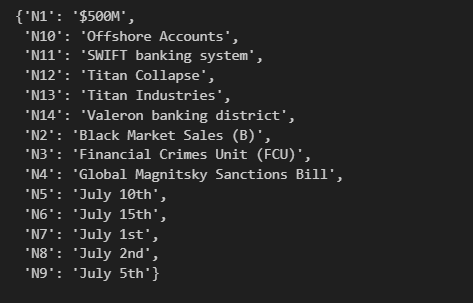

In [ ]:
## Save it, i dont want to mess up

import os
import json
import pprint

# Ensure folder exists
os.makedirs("saved_stuff", exist_ok=True)

# Path to save the file
save_path = "saved_stuff/final_causal_map.json"

# Save using json (ensure keys are strings because JSON cannot store tuple keys)
serializable_map = {str(k): v for k, v in final_causal_map.items()}

with open(save_path, "w") as f:
    json.dump(serializable_map, f, indent=4)

print(f"Saved final_causal_map to {save_path}")


In [ ]:
import json
import pprint

load_path = "saved_stuff/final_causal_map.json"

with open(load_path, "r") as f:
    loaded_map = json.load(f)

print("Loaded map:\n")
# pprint.pprint(loaded_map)

def restore_tuple_keys(d):
    restored = {}
    for k_str, v in d.items():
        k = eval(k_str)  # converts "(1, 2)" → (1, 2)
        restored[k] = v
    return restored

restored_map = restore_tuple_keys(loaded_map)
pprint.pprint(restored_map)
# This is our above 

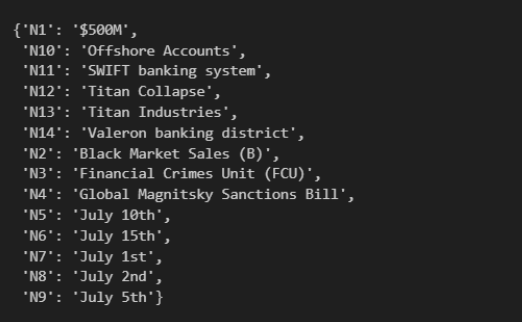

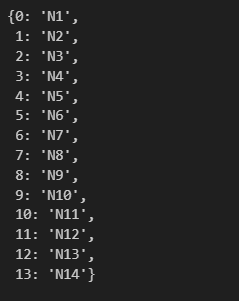

In [ ]:
idx_to_node_name = {
    idx: name
    for idx, name in enumerate(
        sorted(N.keys(), key=lambda x: int(x[1:]) if x != "N0" else 0)
    )
}

pprint.pprint(idx_to_node_name)

In [ ]:
pprint.pprint(node_to_idx)

In [ ]:
# Invert node_to_idx: internal index -> numeric node id (1,2,3,10,...)
idx_to_node_num = {
    idx: int(node_id[1:])   # strip the 'N' and cast to int
    for idx, node_id in idx_to_node_name.items()
}

pprint.pprint(idx_to_node_num)

In [ ]:
## Reverting final_causal_map (i,j) back to the corresponding node indexes (See the above img mapping that was the issue)

# Example: if node_to_idx["N10"] == 4, then idx_to_node_num[4] == 10

remapped_final_causal_map: Dict[Tuple[int, int], Dict[str, Any]] = {}

for (i, j), val in restored_map.items():
    new_i = idx_to_node_num.get(i, i)   # fallback to i if missing
    new_j = idx_to_node_num.get(j, j)   # fallback to j if missing
    remapped_final_causal_map[(new_i, new_j)] = val

# Now remapped_final_causal_map has keys like (10, 3) instead of (4, 2) etc — i.e., tuples in terms of the original N# indices

In [ ]:
pprint.pprint(remapped_final_causal_map)

In [ ]:
# Ideally earlier before this above step there was supposed to be that semantic filter which i never used (I just used a structural filter)..

In [ ]:
# B. Counterfactual Reasoning (Our CoT prompt)

In [ ]:
import time
from typing import Dict, Tuple, Any, List

# Reuse your existing client + LLM_MODEL:
# client = Client(api_key=os.environ["GEMINI_API_KEY"])
# LLM_MODEL = "gemini-2.5-flash"

NS_SAMPLES_CF = 2          # Ns = 5 counterfactual samples
CF_TEMPERATURE = 0.7       # Sampling temperature
CF_DELAY_SECONDS = 15      # 15s delay to respect rate limits


def _parse_reasoning_and_score(raw_text: str) -> Tuple[str, float]:
    """
    Parse the LLM output into (reasoning_string, score_float).

    Expected pattern (soft):
      <some reasoning text...>
      SCORE: <number between 0.0 and 1.0>

    We try to find the last line starting with 'SCORE:' and parse the float.
    If parsing fails, we return score = 0.0 but still keep the reasoning string.
    """
    if raw_text is None:
        return "", 0.0

    text = raw_text.strip()
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]

    score = 0.0
    reasoning = text

    for ln in reversed(lines):
        if ln.upper().startswith("SCORE"):
            # e.g. "SCORE: 0.73"
            parts = ln.split(":")
            if len(parts) >= 2:
                try:
                    score = float(parts[1].strip())
                except ValueError:
                    score = 0.0
            # Reasoning = everything before this SCORE line
            idx = text.rfind(ln)
            if idx != -1:
                reasoning = text[:idx].strip()
            break

    return reasoning, score


def counterfactual_reasoning_for_pairs(
    pairs: List[Tuple[int, int]],
    context_map: Dict[Tuple[int, int], str],
    ns_samples: int = NS_SAMPLES_CF,
    temperature: float = CF_TEMPERATURE,
    delay_seconds: int = CF_DELAY_SECONDS,
) -> Dict[Tuple[int, int], Dict[str, Any]]:
    """
    For each (i, j) and its context, run Ns counterfactual LLM calls:

    Prompt template (conceptual):

      Context: {context}
      1. Reasoning: If i were NOT present, what is the impact on j ? Explain clearly.
      2. Give a confidence score between 0.0 and 1.0.

    Returns:
      {
        (i, j): {
          "context": <str>,
          "reasoning_strings": [r1, r2, ..., r_ns],
          "causal_strength_scores": [s1, s2, ..., s_ns]
        },
        ...
      }
    """
    results: Dict[Tuple[int, int], Dict[str, Any]] = {}

    for (i, j) in pairs:
        pair_key = (int(i), int(j))
        ctx = context_map.get(pair_key, "")

        print(f"\n=== Counterfactual for pair (i={i}, j={j}) ===")
        print(f"Context length: {len(ctx)} chars")

        reasoning_list: List[str] = []
        scores_list: List[float] = []

        # Build the base prompt *once* and resample with different randomness
        base_prompt = f"""
You are a careful causal reasoning assistant.

Context:
\"\"\"{ctx}\"\"\"

We are analyzing the causal influence of i on j.

1. Reasoning: If i were NOT present, what is the impact on j? 
   - Think step by step.
   - Refer only to the information in the Context.
   - Be explicit whether the impact is strong, weak, or negligible.

2. After your explanation, on a new line write:
   SCORE: <a single number between 0.0 and 1.0>

Where:
- SCORE ≈ 0.0 means "almost no causal effect of i on j".
- SCORE ≈ 1.0 means "strong, confident causal effect of i on j".

Return only your explanation and the SCORE line.
"""

        for s_idx in range(ns_samples):
            print(f"  -> Sample {s_idx+1}/{ns_samples} ...")
            try:
                response = client.models.generate_content(
                    model=LLM_MODEL,
                    contents=base_prompt,
                    config=types.GenerateContentConfig(
                        temperature=temperature,
                    ),
                )

                raw_text = getattr(response, "text", "") or ""
                reasoning_s, score_s = _parse_reasoning_and_score(raw_text)

                reasoning_list.append(reasoning_s)
                scores_list.append(score_s)

                print(f"     SCORE parsed = {score_s:.3f}")

            except Exception as e:
                # On any API / parsing error, append placeholders and continue
                print(f"     [Warning] LLM call failed: {e}")
                reasoning_list.append("")
                scores_list.append(0.0)

            # Respect rate-limit between *requests*
            time.sleep(delay_seconds)

        results[pair_key] = {
            "context": ctx,
            "reasoning_strings": reasoning_list,
            "causal_strength_scores": scores_list,
        }

    return results


In [ ]:
final_causal_map  # from run_causal_verification_pipeline(...)
# final_causal_map[(i, j)] = {
#     "verified_causal_hypothesis": [...],
#     "evidence_text": "..."
# }


In [ ]:
# 1. Build context_map from your earlier step (use evidence_text as context)
context_map = {
    pair: data["evidence_text"]
    for pair, data in final_causal_map.items()
}

# 2. Pairs you want to run counterfactual reasoning on
pairs = list(context_map.keys())   # or use E_prior, or any subset

# 3. Run counterfactual reasoning (this will be slow: 5 samples * 15s per sample * |pairs|)
counterfactual_results = counterfactual_reasoning_for_pairs(
    pairs=pairs,
    context_map=context_map,
)

# 4. Inspect
import pprint
pprint.pprint(counterfactual_results)
